## STEP 1

Import Libraries

In [54]:
import pandapower as pp
import pandapower.networks as nw
import pandapower.plotting as plot
import math


Create the Medium Voltage net

In [55]:
net = nw.create_cigre_network_mv(with_der=False)

Run the net

In [56]:
net

This pandapower network includes the following parameter tables:
   - bus (15 elements)
   - load (18 elements)
   - switch (8 elements)
   - ext_grid (1 element)
   - line (15 elements)
   - trafo (2 elements)
   - bus_geodata (15 elements)

# 1.1 

What is the state of the network? Check bus voltage [pu] and line/transformer loading [%]

Consider that the maximum allowed voltage is 1.1 pu, the minimum is 0.9 pu, and the maximum line loading is 100%.

Set the limits for Voltage Per Unit (pu) and for Line loading

In [57]:
bus_max_pu=1.1
bus_min_pu=0.9
max_line_loading=100
max_trafo_loading=100

Run the net

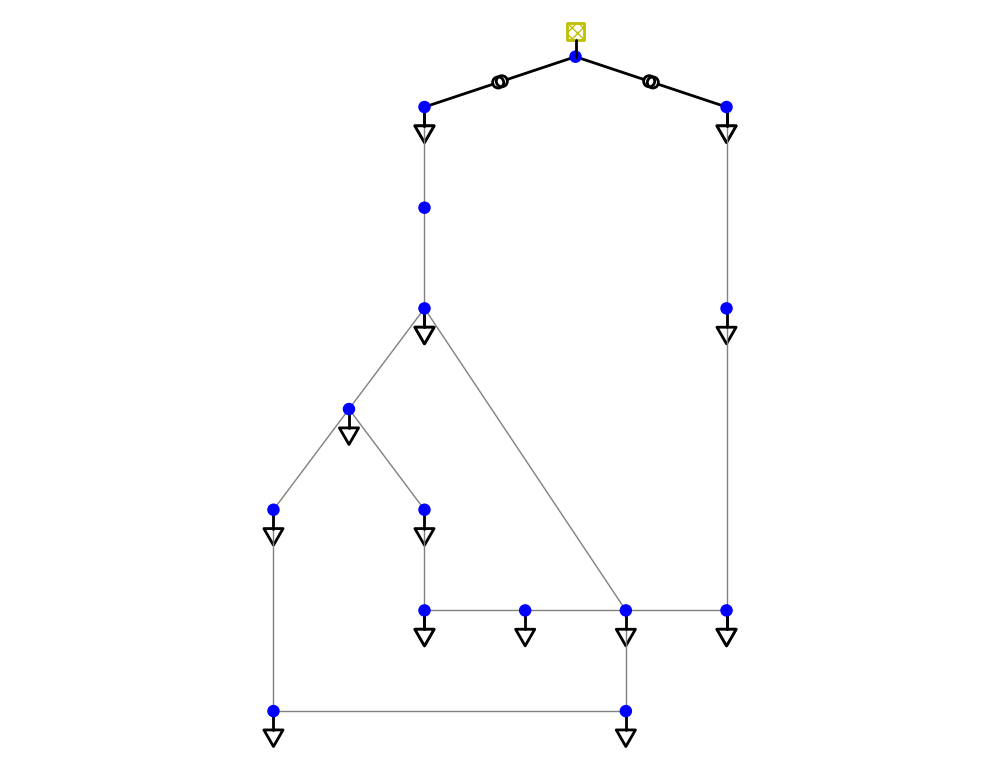

<Axes: >

In [58]:
pp.runpp(net)
plot.simple_plot(net, respect_switches=False, line_width=1.0, bus_size=1.0, ext_grid_size=1.0, trafo_size=1.0, 
                 plot_loads=True, plot_gens=False, plot_sgens=False, 
                 load_size=2, gen_size=1.0, sgen_size=1.0, 
                 switch_size=2.0, switch_distance=1.0, plot_line_switches=False, scale_size=True, 
                 bus_color='b', line_color='grey', trafo_color='k', ext_grid_color='y', switch_color='r', library='igraph', show_plot=True, ax=None)


Define a function to Check if Voltage is within the limits max_pu and min_pu

In [59]:
def checkVoltageRange(max,min,vm_data,component_name):
    print(f'---------{component_name} Voltage Check ---------\n')
    i=0
    faults=0
    for vm in vm_data:
        if vm >= max:
            print(f'{component_name} {i} Voltage is Over the Limit: {round(vm,4)}')
            faults+=1
        elif vm <= min:
            print (f'{component_name} {i} Voltage is Under the Limit: {round(vm,4)}')
            faults+=1
        elif math.isnan(vm):
            print (f'{component_name} {i} is off Grid')
            faults+=1
        i+=1
    if faults==0:
        print(f'OK {component_name} \n')
    else:
        print(f'Number of {component_name} out of Voltage range: {faults}\n ')

Define a function to check if Loading Percent is over a certain Limit

In [60]:
def checkLoadingPercent(limit,loading_data,component_name):
    print(f'---------{component_name} Loading Check ---------\n')
    i=0
    faults=0
    for loading in loading_data:
        if loading > limit:
            print(f'{component_name}  {i} is Overloaded: {round(loading,2)}')
            faults+=1
        elif math.isnan(loading):
            print (f'{component_name} {i} is off Grid')
            faults+=1
        i+=1
    if faults==0:
        print(f'OK {component_name}\n')
    else:
        print(f'Number of Overloaded {component_name} : {faults} \n')
        

Check the requried Network values

In [61]:
checkVoltageRange(bus_max_pu,bus_min_pu,net.res_bus.vm_pu,"Bus")
checkLoadingPercent(max_line_loading,net.res_line.loading_percent,"Line")
checkLoadingPercent(max_trafo_loading,net.res_trafo.loading_percent,"Transformer")

---------Bus Voltage Check ---------

OK Bus 

---------Line Loading Check ---------

OK Line

---------Transformer Loading Check ---------

Transformer  0 is Overloaded: 101.41
Number of Overloaded Transformer : 1 



# 1.2

What happens in the system during a contingency (N-1) case? Are there lines overloaded? Buses above/under the limits?

Consider that the maximum allowed voltage is 1.1 pu, the minimum is 0.9 pu, the maximum line loading is 100% AND all
customers/loads should be supplied with power.

Ignore the switches:
- Line 12 (bus 6 to 7)
- Line 13 (bus 11 to 4)
- Line 14 (bus 14 to 8)

Define a function to check if Load receive power

In [62]:
def load_check(load_data):
    print(f'----------Loads check ---------\n')
    i=0
    faults=0
    for load in load_data:
        if load == 0:
            #print(f'{i} OK')
            faults+=1
        i+=1
    if faults==0:
        print("OK Loads\n")
    else:
        print(f'Number of not served Loads: {faults}\n')

Run the N-1 contingency with the normal limit values

In [63]:

i=0
for i,line in net.line.iterrows():
    if i < 12:  
        #Printing Line Index and From-To Buses   
        print(f'######################## Line {i} ##############################')
        from_bus = line['from_bus']
        to_bus = line['to_bus']
        print(f'From Bus {from_bus} to {to_bus}')

        #Line i Out of service 
        net.line.at[i,'in_service']=False

        #Run the net
        pp.runpp(net)

        #Check the values
        checkVoltageRange(bus_max_pu,bus_min_pu,net.res_bus.vm_pu,"Bus")
        checkLoadingPercent(max_line_loading,net.res_line.loading_percent,"Line")
        checkLoadingPercent(max_trafo_loading,net.res_trafo.loading_percent,"Transformer")
        print(net.res_trafo.loading_percent)
        print(net.res_trafo.p_hv_mw)
        
        load_check(net.res_load.p_mw)
        
        net.line.at[i,'in_service']=True
        i+=1

######################## Line 0 ##############################
From Bus 1 to 2
---------Bus Voltage Check ---------

Bus 2 is off Grid
Bus 3 is off Grid
Bus 4 is off Grid
Bus 5 is off Grid
Bus 6 is off Grid
Bus 7 is off Grid
Bus 8 is off Grid
Bus 9 is off Grid
Bus 10 is off Grid
Bus 11 is off Grid
Number of Bus out of Voltage range: 10
 
---------Line Loading Check ---------

Line 0 is off Grid
Line 1 is off Grid
Line 2 is off Grid
Line 3 is off Grid
Line 4 is off Grid
Line 5 is off Grid
Line 6 is off Grid
Line 7 is off Grid
Line 8 is off Grid
Line 9 is off Grid
Line 12 is off Grid
Line 13 is off Grid
Number of Overloaded Line : 12 

---------Transformer Loading Check ---------

OK Transformer

0    81.319472
1    84.698048
Name: loading_percent, dtype: float64
0    19.865451
1    20.616666
Name: p_hv_mw, dtype: float64
----------Loads check ---------

Number of not served Loads: 11

######################## Line 1 ##############################
From Bus 2 to 3
---------Bus Voltage Che

# 1.3

Run the N-1 contingency with the **Strict** limit values

In [67]:
i=0

bus_max_pu=1.05
bus_min_pu=0.95


for i,line in net.line.iterrows():
    if i < 12:  
        #Printing Line Index and From-To Buses   
        print(f'######################## Line {i} ##############################')
        from_bus = line['from_bus']
        to_bus = line['to_bus']
        print(f'From Bus {from_bus} to {to_bus}')

        #Line i Out of service 
        net.line.at[i,'in_service']=False

        #Run the net
        pp.runpp(net)

        #Check the values
        checkVoltageRange(bus_max_pu,bus_min_pu,net.res_bus.vm_pu,"Bus")
        checkLoadingPercent(max_line_loading,net.res_line.loading_percent,"Line")
        checkLoadingPercent(max_trafo_loading,net.res_trafo.loading_percent,"Transformer")
        load_check(net.res_load.p_mw)
        
        net.line.at[i,'in_service']=True
        i+=1

######################## Line 0 ##############################
From Bus 1 to 2
---------Bus Voltage Check ---------

Bus 2 is off Grid
Bus 3 is off Grid
Bus 4 is off Grid
Bus 5 is off Grid
Bus 6 is off Grid
Bus 7 is off Grid
Bus 8 is off Grid
Bus 9 is off Grid
Bus 10 is off Grid
Bus 11 is off Grid
Number of Bus out of Voltage range: 10
 
---------Line Loading Check ---------

Line 0 is off Grid
Line 1 is off Grid
Line 2 is off Grid
Line 3 is off Grid
Line 4 is off Grid
Line 5 is off Grid
Line 6 is off Grid
Line 7 is off Grid
Line 8 is off Grid
Line 9 is off Grid
Line 12 is off Grid
Line 13 is off Grid
Number of Overloaded Line : 12 

---------Transformer Loading Check ---------

OK Transformer

----------Loads check ---------

Number of not served Loads: 11

######################## Line 1 ##############################
From Bus 2 to 3
---------Bus Voltage Check ---------

Bus 3 is off Grid
Bus 4 is off Grid
Bus 5 is off Grid
Bus 6 is off Grid
Bus 7 is off Grid
Bus 8 is off Grid
Bus 9 

## STEP 2

Add load shapes to existing customers (time series simulation)

In [79]:
#Create the network with timeseires allowed

net = nw.create_cigre_network_mv()
#print(net.load)
print(net.load)

         name  bus      p_mw    q_mvar  const_z_percent  const_i_percent   
0     Load R1    1  14.99400  3.044662              0.0              0.0  \
1     Load R3    3   0.27645  0.069285              0.0              0.0   
2     Load R4    4   0.43165  0.108182              0.0              0.0   
3     Load R5    5   0.72750  0.182329              0.0              0.0   
4     Load R6    6   0.54805  0.137354              0.0              0.0   
5     Load R8    8   0.58685  0.147078              0.0              0.0   
6    Load R10   10   0.47530  0.119121              0.0              0.0   
7    Load R11   11   0.32980  0.082656              0.0              0.0   
8    Load R12   12  14.99400  3.044662              0.0              0.0   
9    Load R14   14   0.20855  0.052268              0.0              0.0   
10   Load CI1    1   4.84500  1.592474              0.0              0.0   
11   Load CI3    3   0.22525  0.139597              0.0              0.0   
12   Load CI